In [1]:
import astropy.utils.data
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp
import ligo.skymap.io
from astropy.io import fits
#import cv2
import seaborn as sns


from astropy.table import Table, vstack, hstack, Column
import astropy.units as u
from astropy.coordinates import SkyCoord
import ligo.skymap.plot
from scipy.stats import norm
import scipy.stats
from scipy.integrate import simpson
import pandas as pd
import os
#from astroquery.vizier import VizierClass
from ligo.skymap.postprocess import crossmatch
import ligo.skymap.io
from ligo.skymap.io import read_sky_map
from ligo.skymap.plot import marker
from ligo.skymap import io
from ligo.skymap.distance import (parameters_to_marginal_moments, principal_axes, volume_render, marginal_pdf)
import scipy.stats
import astropy_healpix as ah
from matplotlib import gridspec
from matplotlib import transforms
#from ligo.skymap.tool.matplotlib import figure_parser
from ligo.skymap.tool import ArgumentParser, FileType
from tqdm import tqdm
import ligo.skymap.tool


## Start Here

/home/tamojeet/.local/lib/python3.8/site-packages/healpy/pixelfunc.py:1978: RuntimeWarning: invalid value encountered in multiply
  map_out = np.sum(mr * goods, axis=1).astype(type_out)


<Figure size 1200x1000 with 0 Axes>

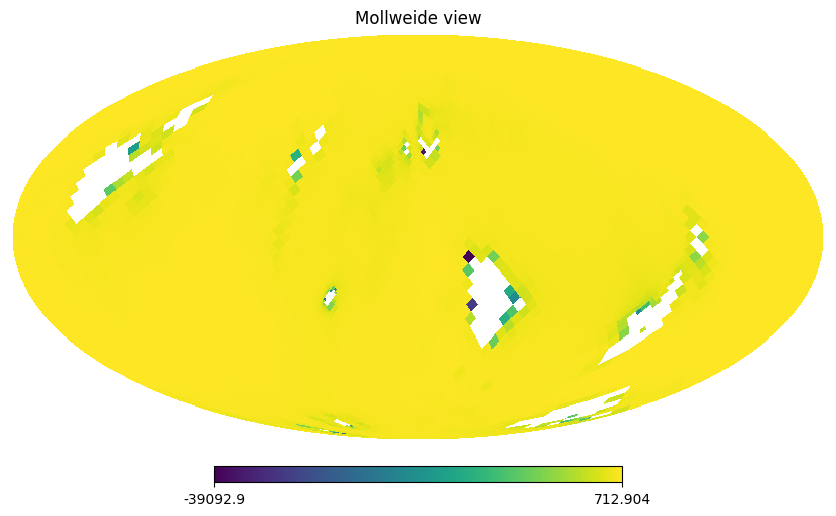

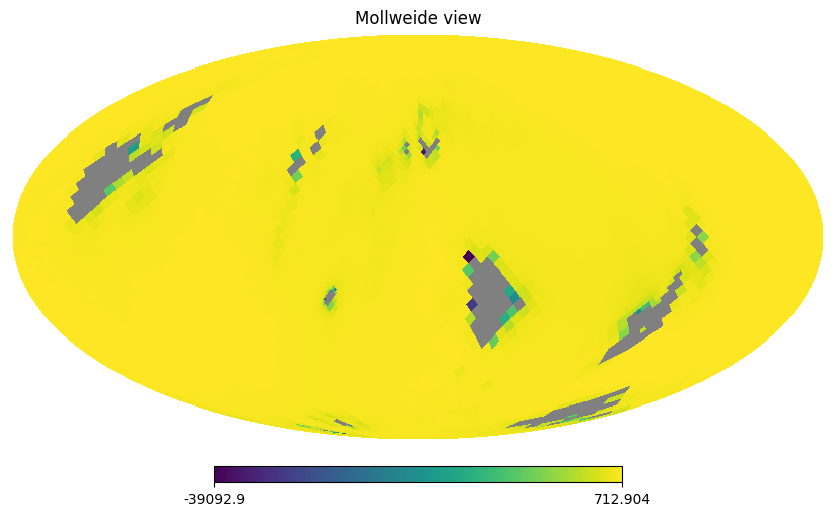

In [1]:
import numpy as np
import pandas as pd
import ligo.skymap.io
import healpy as hp
import matplotlib.pyplot as plt


    
    


skym = ligo.skymap.io.fits.read_sky_map('bns_astro/allsky/111.fits', distances=True)
skymap = hp.ud_grade(skym[0][1], 512)

plt.figure(figsize=(12,10))
hp.mollview(skym[0][1])
hp.mollview(skymap)

In [7]:
np.sum(skymap)

0.25000000000000033

<Figure size 1200x1000 with 0 Axes>

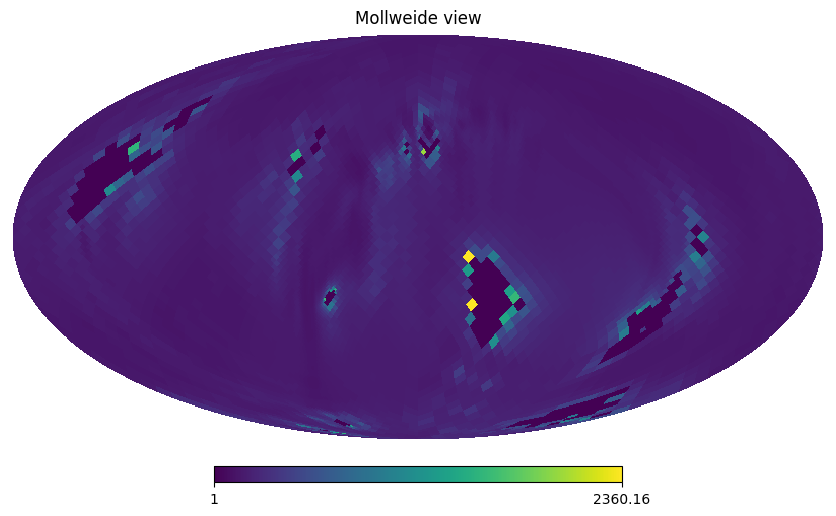

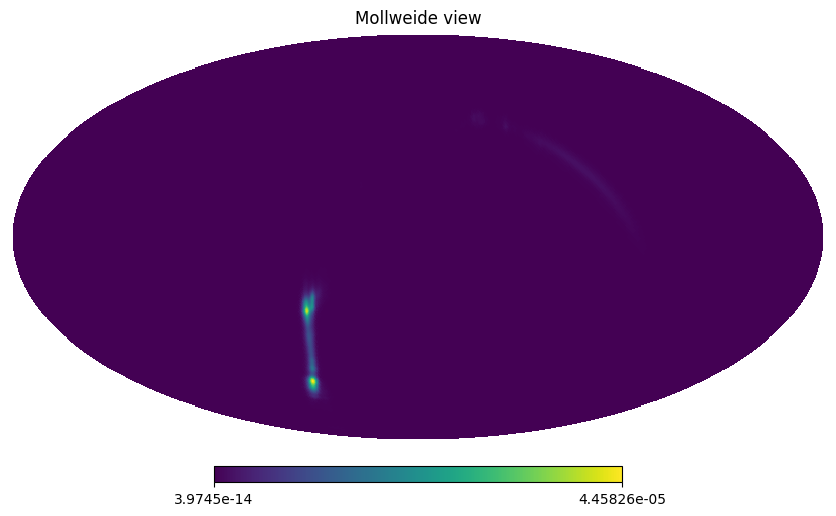

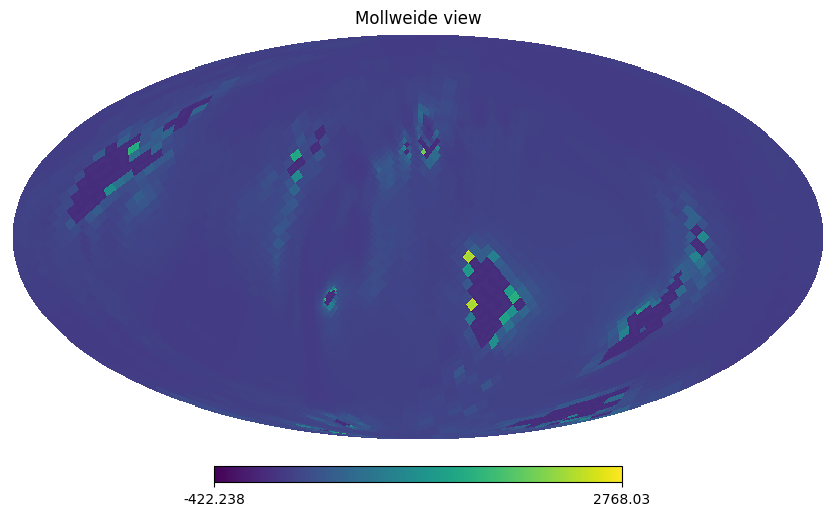

In [11]:
#skym = ligo.skymap.io.fits.read_sky_map('bns_astro/allsky/111.fits', distances=True)
#skymap = skym[0][1]

plt.figure(figsize=(12,10))
hp.mollview(skym[0][2])
hp.mollview(skym[0][0])

a = hp.sphtfunc.map2alm(skym[0][2])
m = hp.sphtfunc.alm2map(a, 512)
hp.mollview(m)

### Good Maps Set 2:

121 (0.99 - 8240)  
243 (0.99 - 7961)

### Mean Distance + Number of Tiles Calculation Cell

In [1]:
import numpy as np
import pandas as pd
import ligo.skymap.io
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

import ligo.skymap.io
import healpy as hp
import matplotlib.pyplot as plt


skym = ligo.skymap.io.fits.read_sky_map('bns_astro/allsky/316.fits', distances=True)
skymap = hp.ud_grade(skym[0][0], 512)
print('Yes')

def get_probabilities(skymap, ra, dec, radius=0.35*u.deg):
    """
    Compute the probabilities covered in a grid of ra, dec with radius
    given a healpix skymap

    Pass the legal RA and Dec lists to this function

    Note: this radius is such that for the default sky grid (nside=128),
    fields overlap such that the area of the sky becomes 1.83 * 4pi steradians.
    As a result, the sum of probabilities will be 1.83
    """
    # fact : int, optional
    # Only used when inclusive=True. The overlapping test will be done at
    # the resolution fact*nside. For NESTED ordering, fact must be a power of 2, less than 2**30,
    # else it can be any positive integer. Default: 4.
    fact = 1
    nside_skymap = hp.npix2nside(len(skymap))
    tile_area = np.pi * radius.to(u.deg).value ** 2
    pixel_area = hp.nside2pixarea(nside_skymap, degrees=True)
    probabilities = np.zeros(len(ra))
    vecs = hp.ang2vec(ra.to(u.deg).value, dec.to(u.deg).value, lonlat=True)
    for i in range(len(ra)):
        sel_pix = hp.query_disc(nside_skymap, vecs[i], radius.to(
            u.rad).value, inclusive=True, fact=fact)
        probabilities[i] = np.sum(skymap[sel_pix]) * \
            tile_area / pixel_area / len(sel_pix)
    return probabilities



def get_top_tiles(probabilities, frac=0.99):
    """
    probabilities may not add up to 1
    return indices of tiles that add up to frac of total
    """
    sortorder = np.argsort(probabilities)
    p_cum = np.cumsum(probabilities[sortorder]) / np.sum(probabilities)
    startind = np.where(p_cum > 1 - frac)[0][0]
    top_tiles = sortorder[startind:]
    return np.flip(top_tiles)




tiles = pd.read_csv('tiles_GIT_7.csv')
ralist, declist = np.array(tiles['RA_Center'])*u.deg, np.array(tiles['DEC_Center'])*u.deg

probs = get_probabilities(skymap, ralist, declist)
tt = get_top_tiles(probs)
len(tt)


Yes


34581

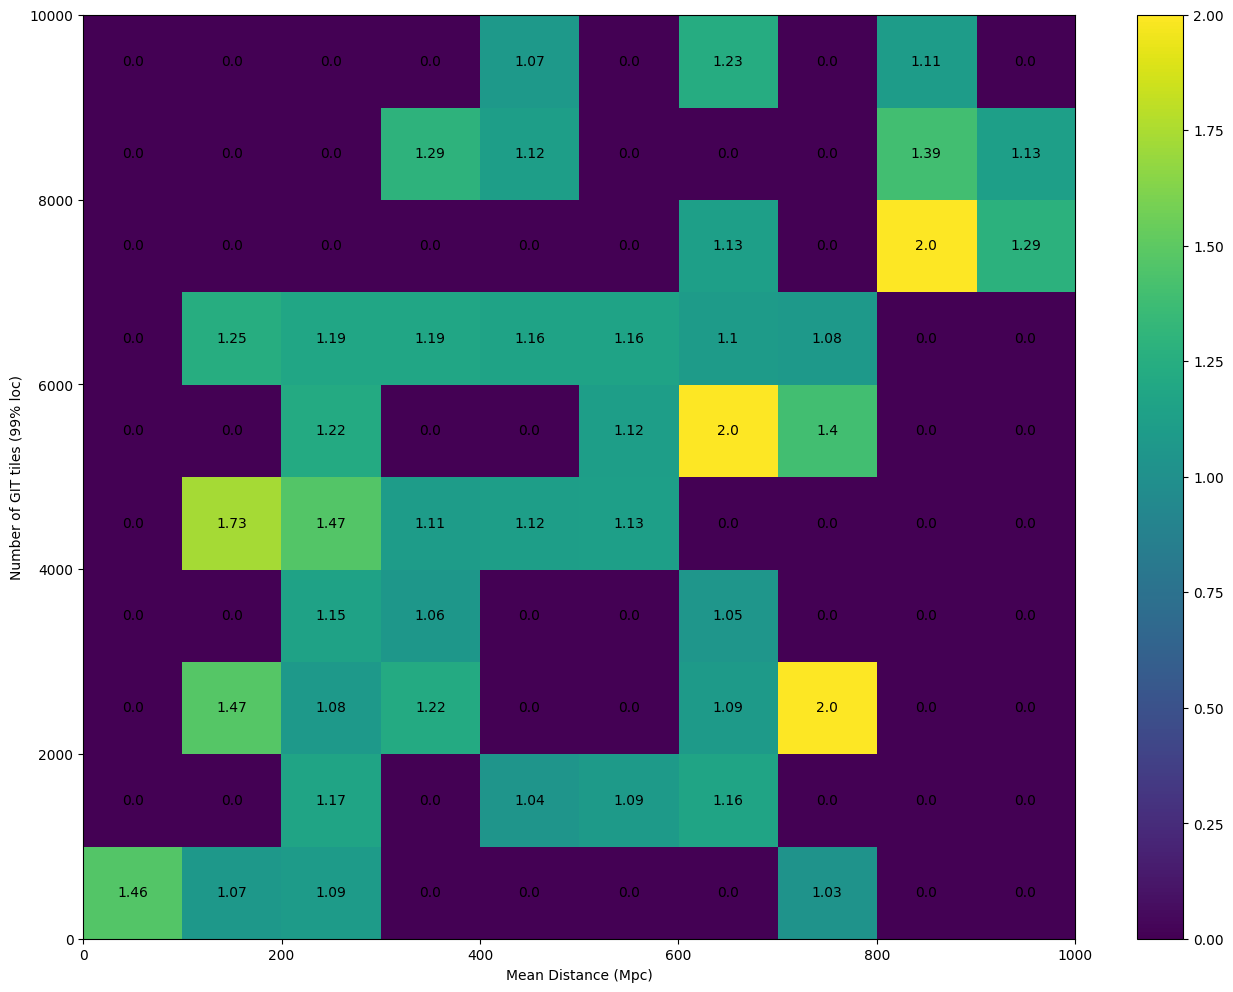

In [12]:
import numpy as np
import matplotlib.pyplot as plt
m = np.zeros((10,10))


dr = np.arange(50,951,100)
ta = np.arange(500,9501,1000)

for i in range(len(dr)):
    for j in range(len(ta)):
        n = d[(np.abs(d.Mean_Dist - dr[i]) <= 50) & (np.abs(d.Area99 - ta[j]) <= 500)]
        
        if len(n) != 0:
            m[j,i] = np.mean(n.P_massfill/n.P_3dcat)
            

            
size = 10
#data = m

# Limits for the extent
x_start = 0
x_end = 1000
y_start = 0
y_end = 10000

extent = [x_start, x_end, y_start, y_end]

# The normal figure
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow(data, extent=extent, origin='lower', interpolation='None', cmap='viridis', aspect='auto')

# Add the text
jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = data[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        ax.text(text_x, text_y, np.round(label,2), color='black', ha='center', va='center')

fig.colorbar(im)
plt.ylabel('Number of GIT tiles (99% loc)')
plt.xlabel('Mean Distance (Mpc)')
plt.show()

0
395.47232317099804
5266


<Figure size 1200x1000 with 0 Axes>

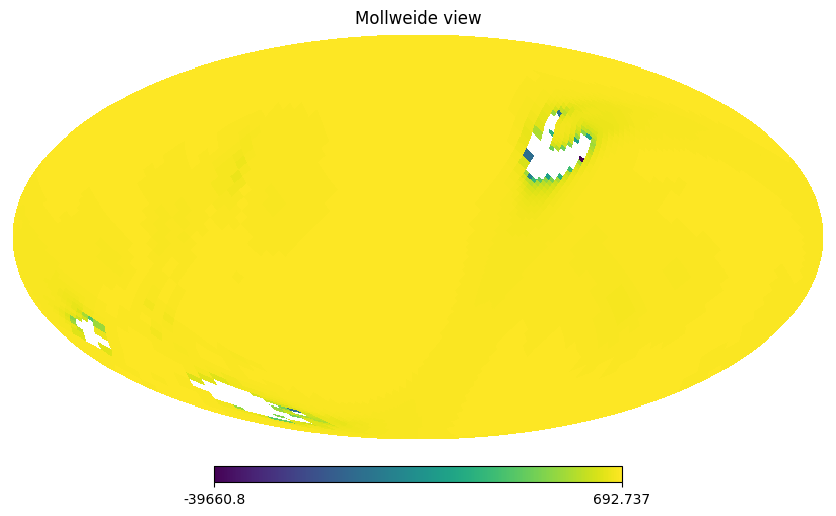

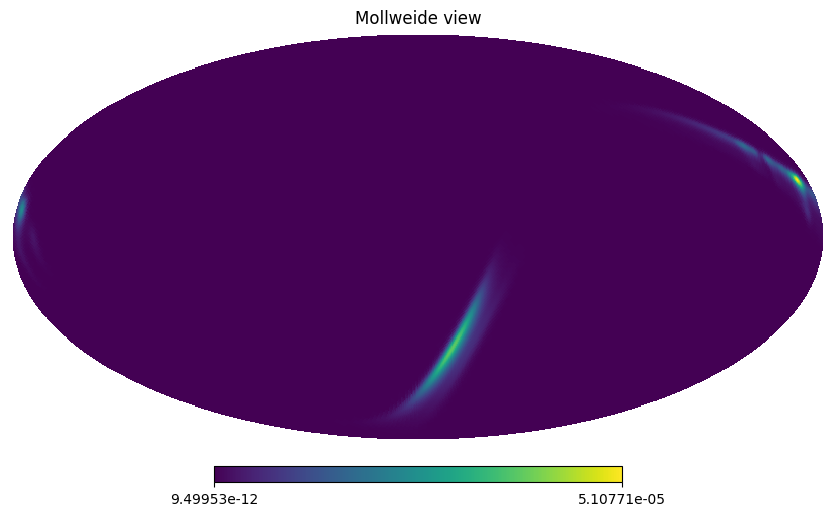

In [12]:
skym = ligo.skymap.io.fits.read_sky_map('bns_astro/allsky/977.fits', distances=True)
plt.figure(figsize=(12,10))
hp.mollview(skym[0][1])
hp.mollview(skym[0][0])

def get_top_tiles(probabilities, frac=0.99):
    """
    probabilities may not add up to 1
    return indices of tiles that add up to frac of total
    """
    sortorder = np.argsort(probabilities)
    p_cum = np.cumsum(probabilities[sortorder]) / np.sum(probabilities)
    startind = np.where(p_cum > 1 - frac)[0][0]
    top_tiles = sortorder[startind:]
    return np.flip(top_tiles)

tt = get_top_tiles(skym[0][0])
li = len(tt)
tt = tt[~np.isinf(skym[0][1][tt])]
print(li-len(tt))


print(np.sum(skym[0][0][tt]*skym[0][1][tt])/np.sum(skym[0][0][tt]))
len(tt)

skymap = hp.ud_grade(skym[0][0], 512)
probs = get_probabilities(skymap, ralist, declist)
tt = get_top_tiles(probs, 0.99)
print(len(tt))

In [30]:
tt = get_top_tiles(skym[0][0])
len(np.where(np.isinf(skym[0][1][tt])))/len(tt)

1.400348406683583e-06

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

import ligo.skymap.io
import healpy as hp
import matplotlib.pyplot as plt


skym = ligo.skymap.io.fits.read_sky_map('bns_astro/allsky/316.fits', distances=True)
skymap = hp.ud_grade(skym[0][0], 512)
print('Yes')

def get_probabilities(skymap, ra, dec, radius=0.35*u.deg):
    """
    Compute the probabilities covered in a grid of ra, dec with radius
    given a healpix skymap

    Pass the legal RA and Dec lists to this function

    Note: this radius is such that for the default sky grid (nside=128),
    fields overlap such that the area of the sky becomes 1.83 * 4pi steradians.
    As a result, the sum of probabilities will be 1.83
    """
    # fact : int, optional
    # Only used when inclusive=True. The overlapping test will be done at
    # the resolution fact*nside. For NESTED ordering, fact must be a power of 2, less than 2**30,
    # else it can be any positive integer. Default: 4.
    fact = 1
    nside_skymap = hp.npix2nside(len(skymap))
    tile_area = np.pi * radius.to(u.deg).value ** 2
    pixel_area = hp.nside2pixarea(nside_skymap, degrees=True)
    probabilities = np.zeros(len(ra))
    vecs = hp.ang2vec(ra.to(u.deg).value, dec.to(u.deg).value, lonlat=True)
    for i in range(len(ra)):
        sel_pix = hp.query_disc(nside_skymap, vecs[i], radius.to(
            u.rad).value, inclusive=True, fact=fact)
        probabilities[i] = np.sum(skymap[sel_pix]) * \
            tile_area / pixel_area / len(sel_pix)
    return probabilities



def get_top_tiles(probabilities, frac=0.99):
    """
    probabilities may not add up to 1
    return indices of tiles that add up to frac of total
    """
    sortorder = np.argsort(probabilities)
    p_cum = np.cumsum(probabilities[sortorder]) / np.sum(probabilities)
    startind = np.where(p_cum > 1 - frac)[0][0]
    top_tiles = sortorder[startind:]
    return np.flip(top_tiles)




tiles = pd.read_csv('tiles_GIT_7.csv')
ralist, declist = np.array(tiles['RA_Center'])*u.deg, np.array(tiles['DEC_Center'])*u.deg

probs = get_probabilities(skymap, ralist, declist)
tt = get_top_tiles(probs)
len(tt)


Yes


34581

In [6]:
skym = ligo.skymap.io.fits.read_sky_map('bns_astro/allsky/47.fits', distances=True)
skymap = skym[0][0]

np.sqrt(len(skymap)/12)

1024.0

In [14]:
cat2 = pd.read_csv('../../reduced_gal_cat.csv')
new = pd.read_csv('../../missing_mass.csv')

In [24]:
skym = ligo.skymap.io.fits.read_sky_map('bns_astro/allsky/347.fits', distances=True)
skymap = hp.ud_grade(skym[0][0], 512)

tiles = pd.read_csv('tiles_GIT_7.csv')
ralist, declist = np.array(tiles['RA_Center'])*u.deg, np.array(tiles['DEC_Center'])*u.deg
probs = get_probabilities(skymap, ralist, declist)
tt = get_top_tiles(probs, 0.99)
len(tt)

distmu = hp.ud_grade(skym[0][1], 512)
distsigma = hp.ud_grade(skym[0][2], 512)
prob2d = hp.ud_grade(skym[0][0], 512)


radius = 0.35*u.deg
fact = 1
nside_skymap = 512

tile_area = np.pi * radius.to(u.deg).value ** 2
pixel_area = hp.nside2pixarea(nside_skymap, degrees=True)

sigma_m = np.zeros(len(tt))

mpcd = np.arange(0,1001,20)


sigma_m_empty_dist = np.zeros(len(tt))
sigma_m_empty_nodist = np.zeros(len(tt))
sigma_m_nonempty = np.zeros(len(tt))


for h in range(len(tt)):
    ra = ralist[tt[h]]
    dec = declist[tt[h]]
    
    vecs = hp.ang2vec(ra.to(u.deg).value, dec.to(u.deg).value, lonlat=True)

    sel_pix = hp.query_disc(nside_skymap, vecs, radius.to(u.rad).value, inclusive=True, fact=fact)

    masses1 = np.zeros(len(sel_pix))
    masses2 = np.zeros(len(sel_pix))
    masses3 = np.zeros(len(sel_pix))

    mpcd = np.arange(0,1001,20)

    for j in range(len(sel_pix)):
        i = sel_pix[j]
        currcat = (cat2[cat2.PIX_ID_512 == i][['Dist','Mstar']])

        currcat.reset_index(drop=True, inplace=True)

        indices = np.arange(0,50,1)
        filled = []

        distfact = 1/distsigma[i] * np.exp( -(mpcd-distmu[i])**2 / (2*distsigma[i]**2) )

        for k in range(len(currcat)):
            ind = np.argmin(np.abs(new['distcen'] - currcat['Dist'][k]))
            filled.append(ind)
            
        unfilled = np.delete(indices, filled)
        masses1[j] = prob2d[i]*(np.sum(currcat['Mstar']*distfact[filled]) + np.sum(new['masstofill'][unfilled]*distfact[unfilled] / (new['num_empty_pixels'][unfilled])))

        masses2[j] = prob2d[i]*np.sum(currcat['Mstar']*distfact[filled])

        masses3[j] = prob2d[i]*np.sum(currcat['Mstar'])

    prob2d[sel_pix] = 0.0

    sigma_m_empty_dist[h] = np.sum(masses2)
    sigma_m_empty_nodist[h] = np.sum(masses3)
    sigma_m_nonempty[h] = np.sum(masses1)
    print(h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
df = pd.DataFrame({'Filled3D':sigma_m_nonempty, 'Unfilled3D':sigma_m_empty_dist, 'Unfilled2D':sigma_m_empty_nodist})
df.to_csv('BNS_GalCat/BNS_347.csv')

### Contribution from Catalog and Missing:

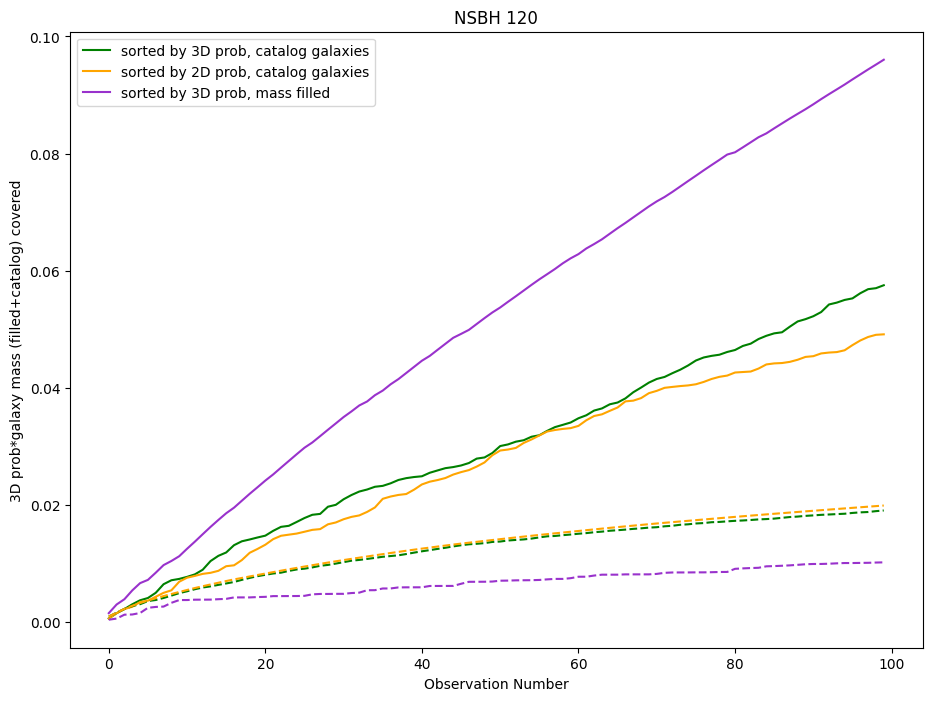

1.6701057583059267


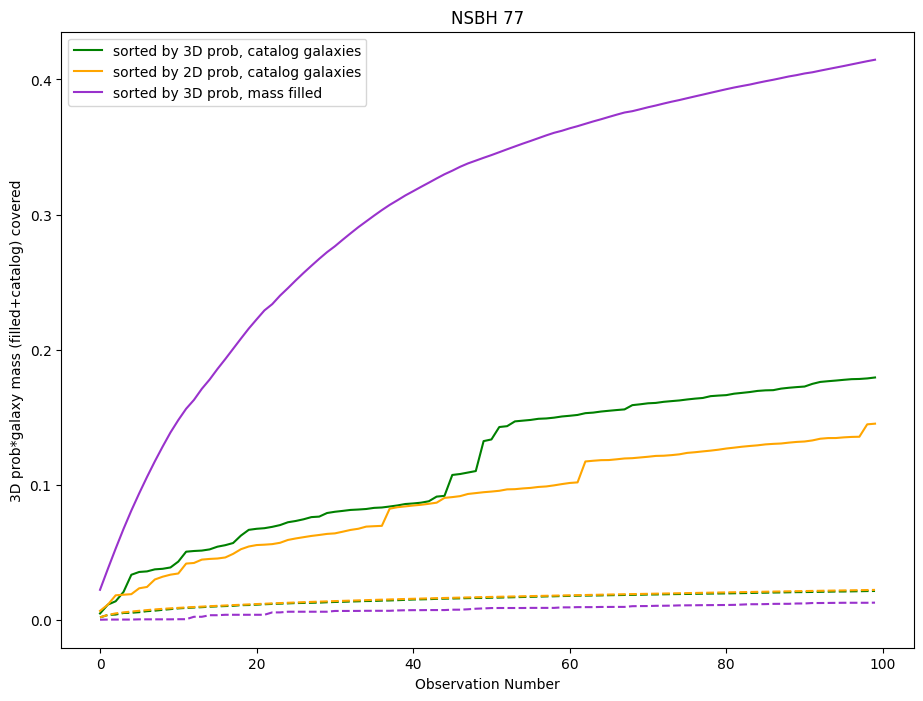

2.311621244340243


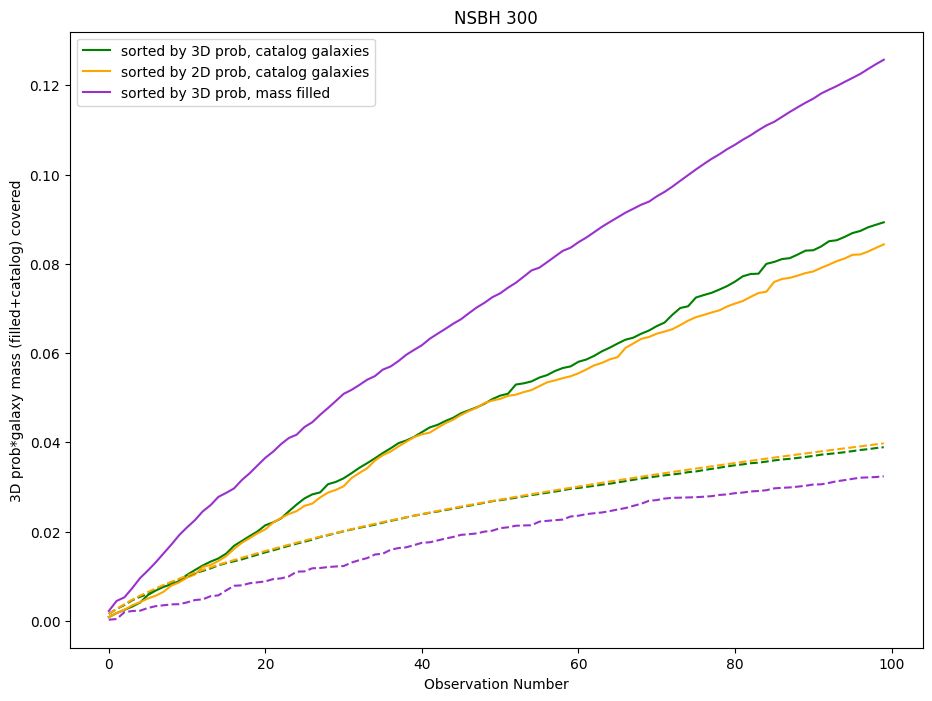

1.4079694487816266


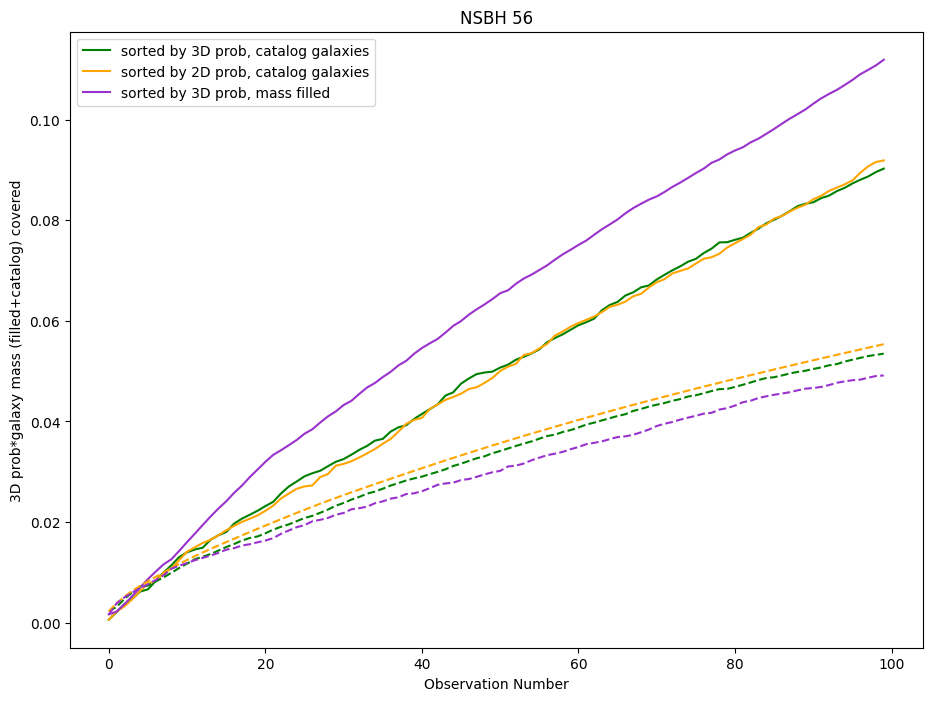

1.2399165880143477


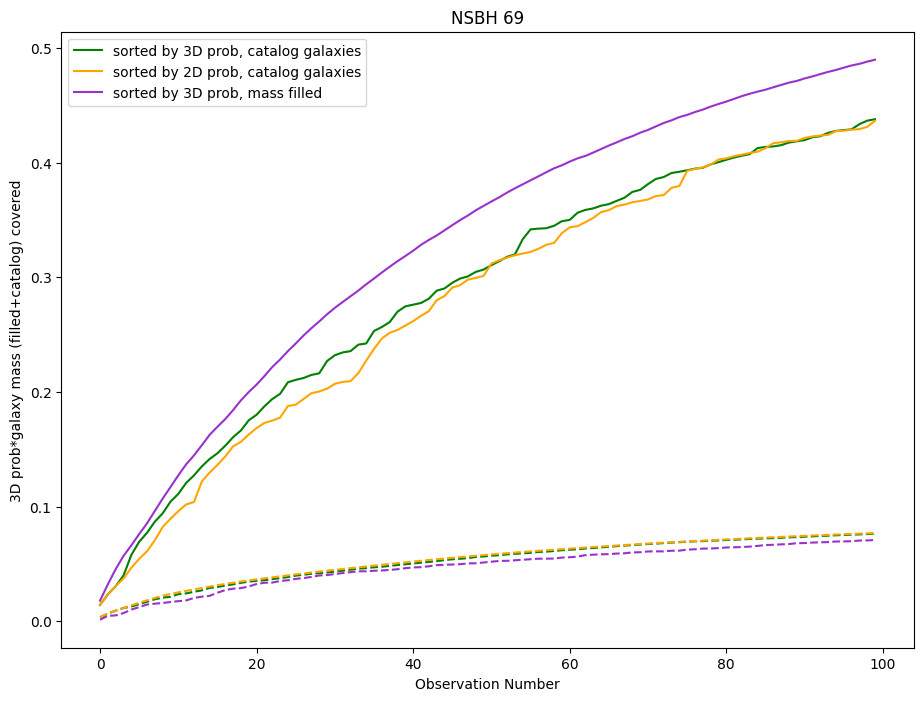

1.1184997920564204


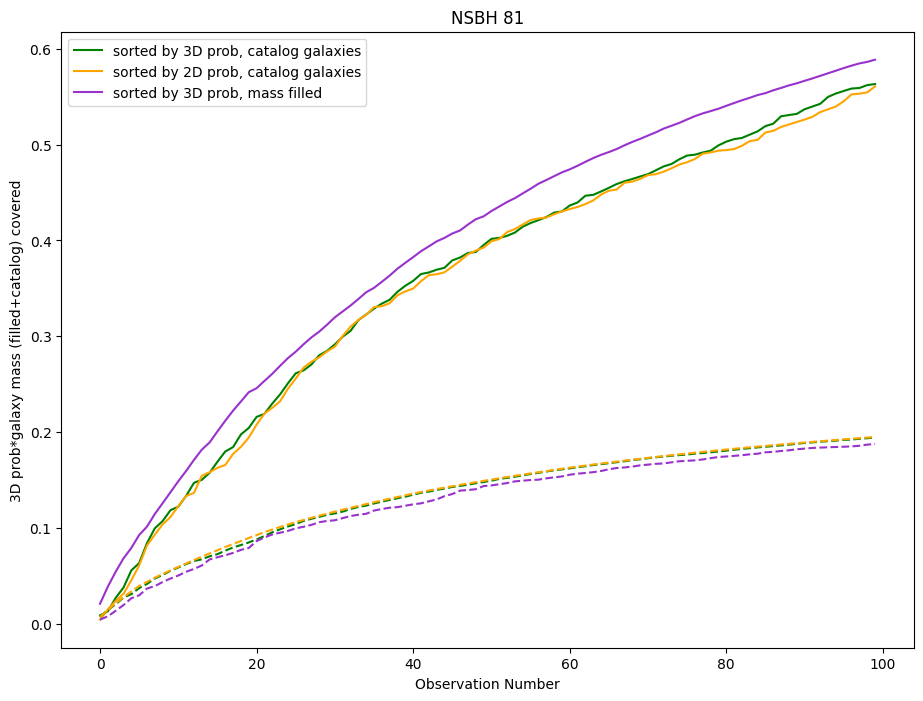

1.0451037582411264


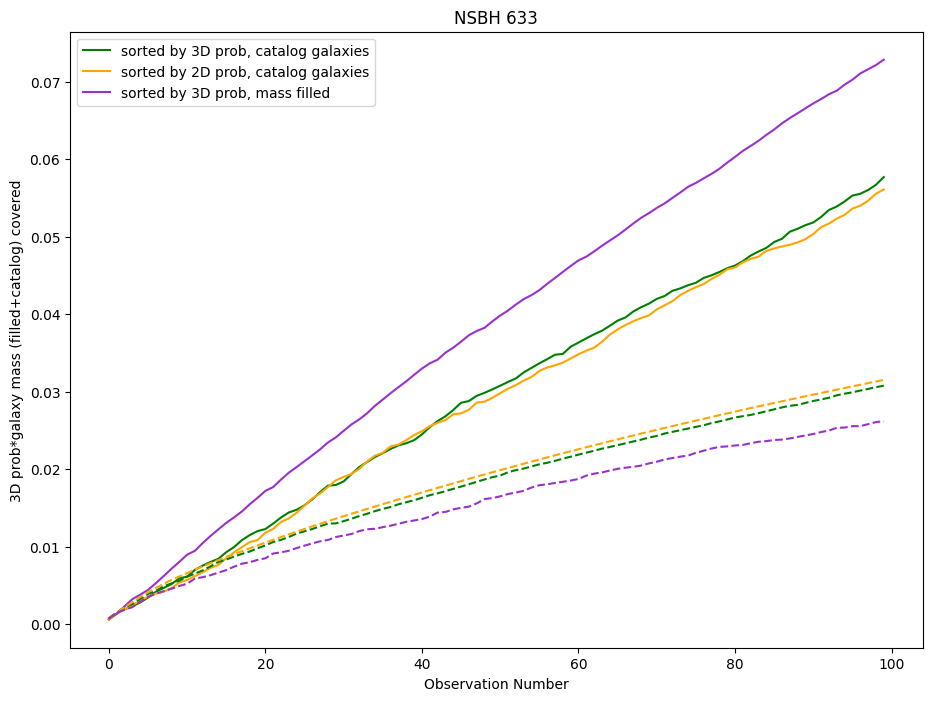

1.262453685237864


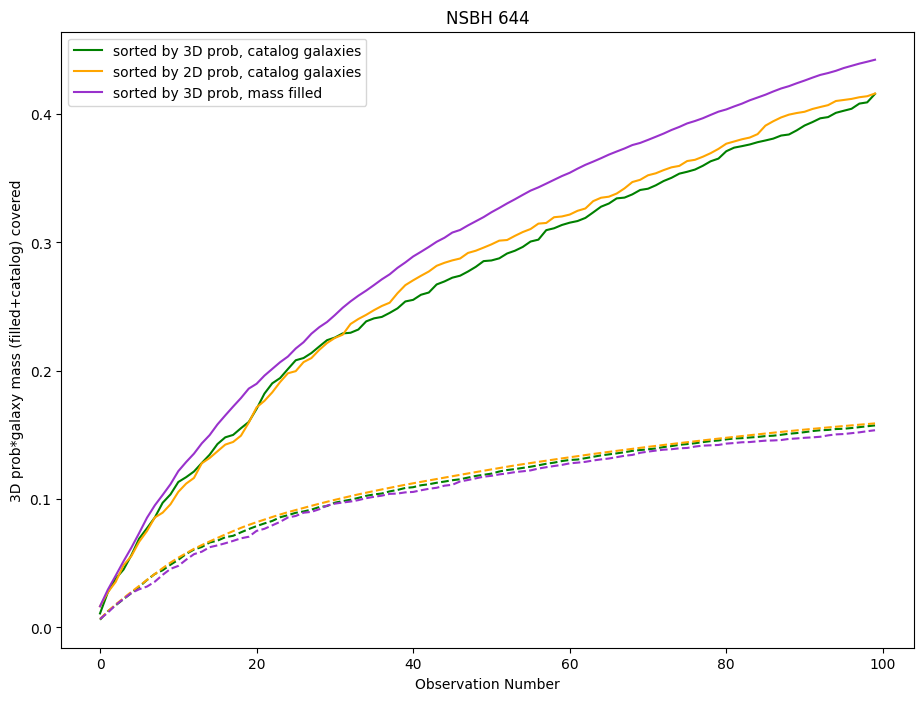

1.0639669956330142


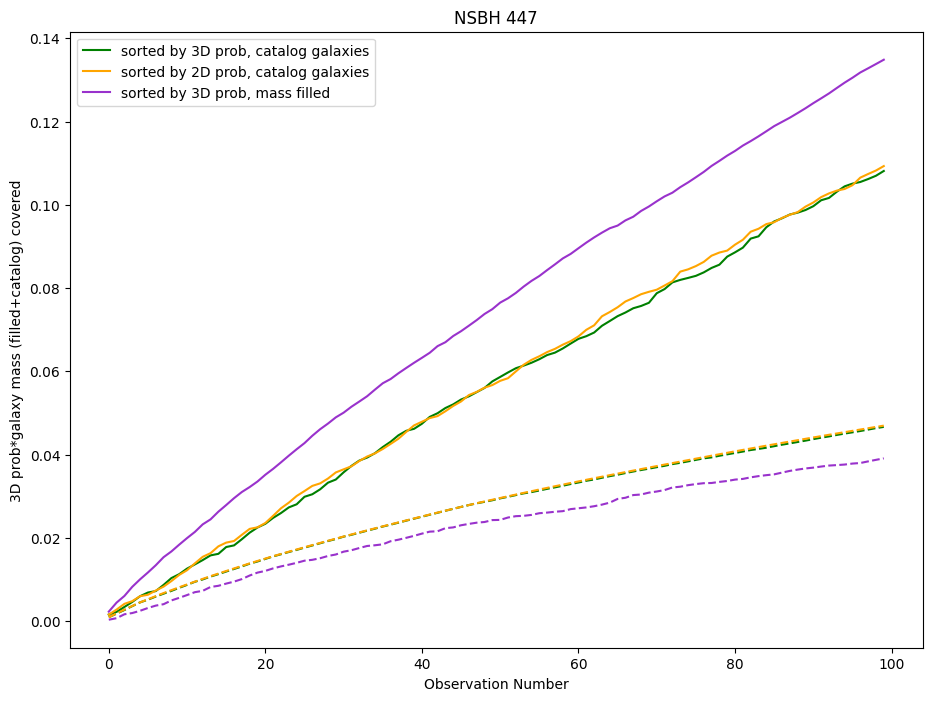

1.2471141737583242


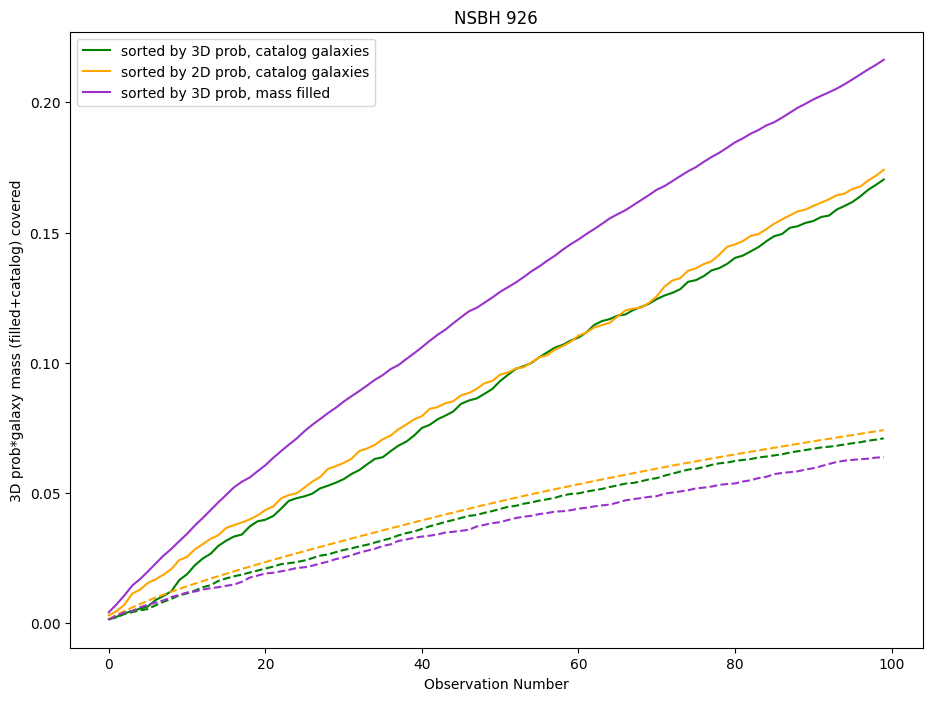

1.269858387756023


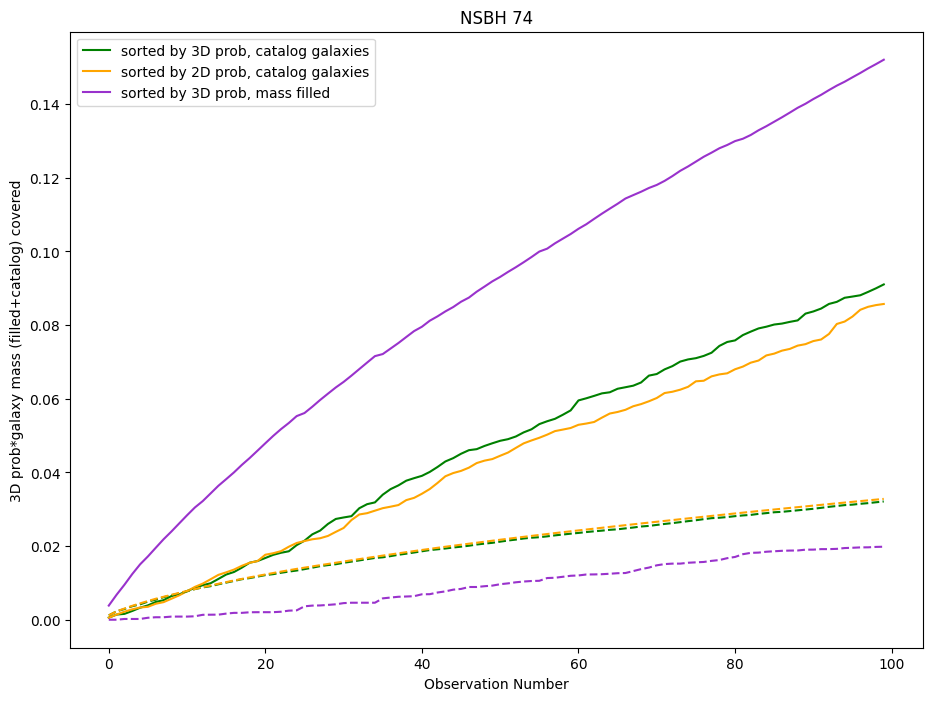

1.6701396310890464


In [26]:
nobs = 100

kl = [33, 40, 55, 77, 88, 111]
#sigma_m = sigma_m[:1008]

for k in kn:
    cs = pd.read_csv('BNS_GalCat/NSBH_{}.csv'.format(k))
    sigma_m_nonempty, sigma_m_empty_nodist, sigma_m_empty_dist = np.array(cs['Filled3D']), np.array(cs['Unfilled2D']), np.array(cs['Unfilled3D'])

    order_dist = np.flip(np.argsort(sigma_m_empty_dist)[-nobs:])
    order_nodist = np.flip(np.argsort(sigma_m_empty_nodist)[-nobs:])
    order_all = np.flip(np.argsort(sigma_m_nonempty)[-nobs:])


    fullsum = np.sum(sigma_m_nonempty)
    a1 = np.cumsum((sigma_m_nonempty-sigma_m_empty_dist)[order_nodist]) / fullsum
    a2 = np.cumsum((sigma_m_nonempty-sigma_m_empty_dist)[order_dist]) / fullsum
    a3 = np.cumsum((sigma_m_nonempty-sigma_m_empty_dist)[order_all]) / fullsum
    
    b1 = np.cumsum((sigma_m_empty_dist)[order_nodist]) / fullsum
    b2 = np.cumsum((sigma_m_empty_dist)[order_dist]) / fullsum
    b3 = np.cumsum((sigma_m_empty_dist)[order_all]) / fullsum


    plt.figure(figsize=(11,8))
    plt.plot(a1, color='green', label='sorted by 3D prob, catalog galaxies')
    plt.plot(a2, color='orange', label = 'sorted by 2D prob, catalog galaxies')
    plt.plot(a3, color='darkorchid', label = 'sorted by 3D prob, mass filled')
    plt.plot(b1, color='green', linestyle='--')
    plt.plot(b2, color='orange', linestyle='--')
    plt.plot(b3, color='darkorchid', linestyle='--')
    plt.legend()
    plt.xlabel('Observation Number')
    plt.ylabel('3D prob*galaxy mass (filled+catalog) covered')
    plt.title('NSBH {}'.format(k))
    plt.show()

    print(a3[-1]/a1[-1])

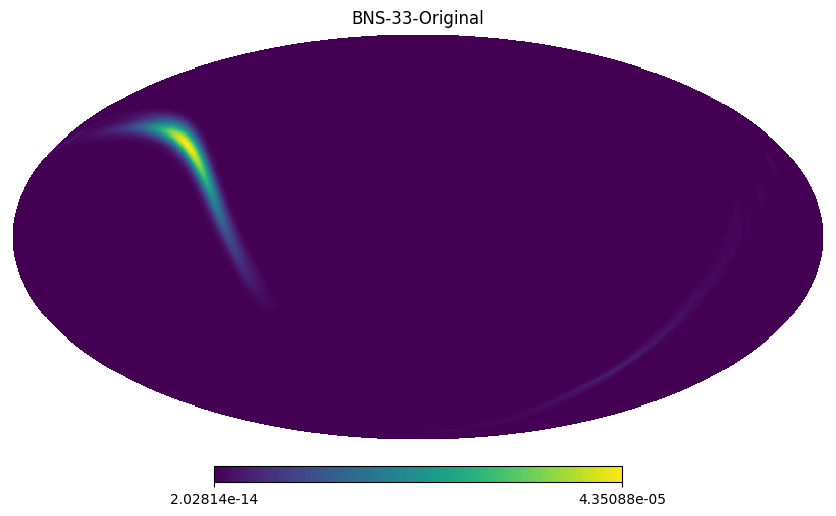

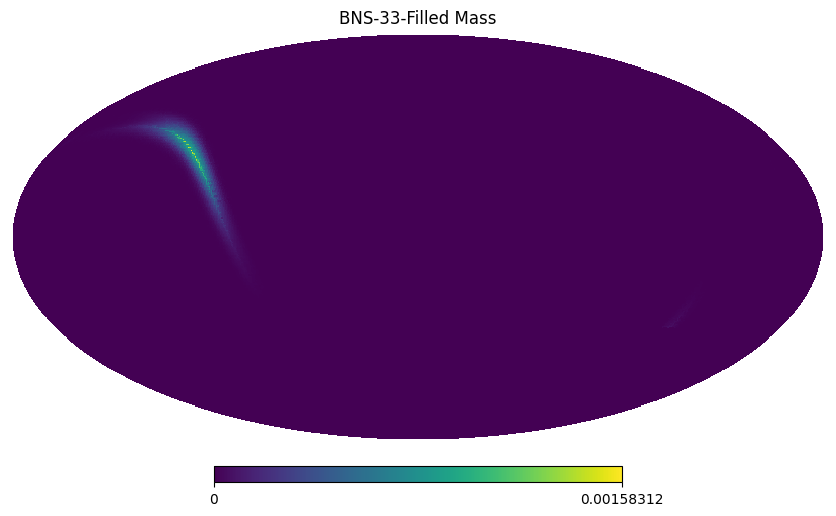

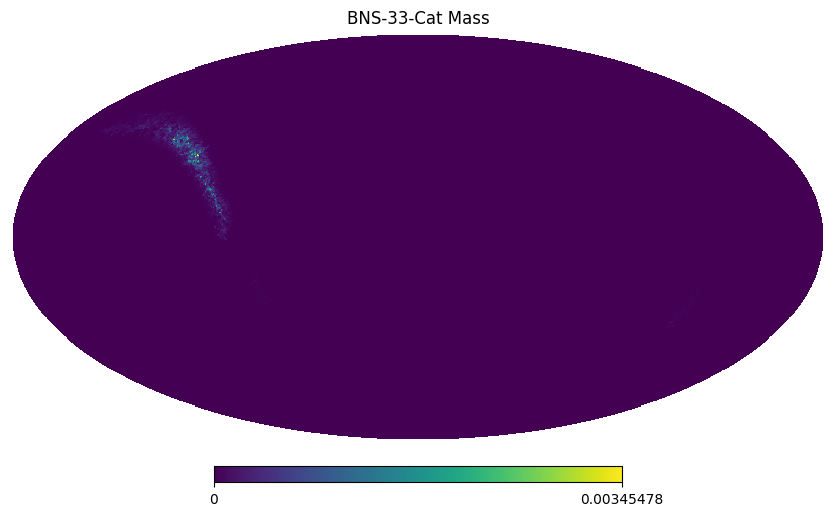

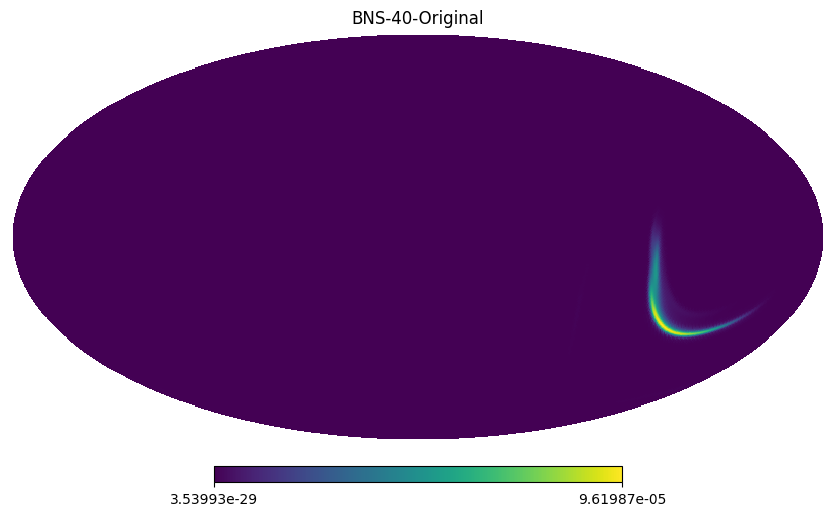

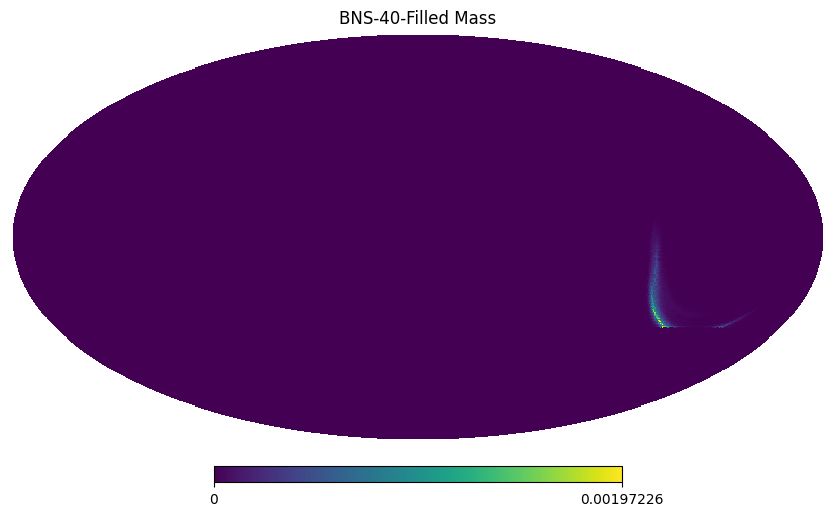

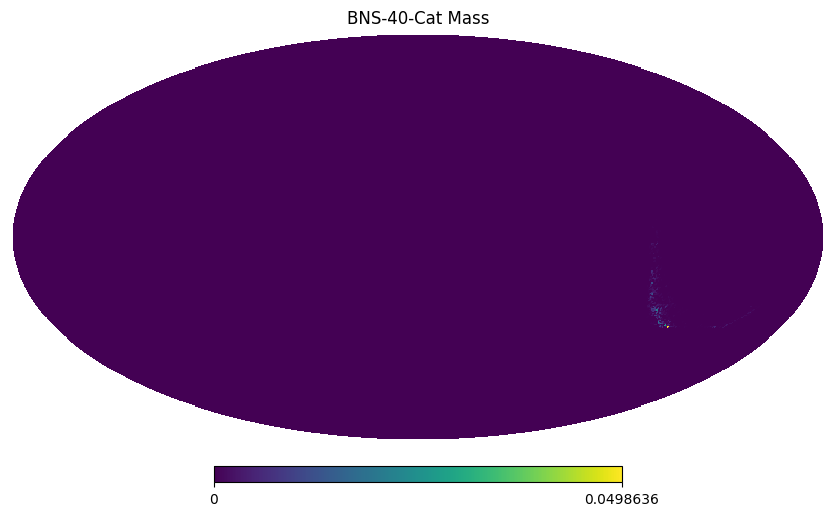

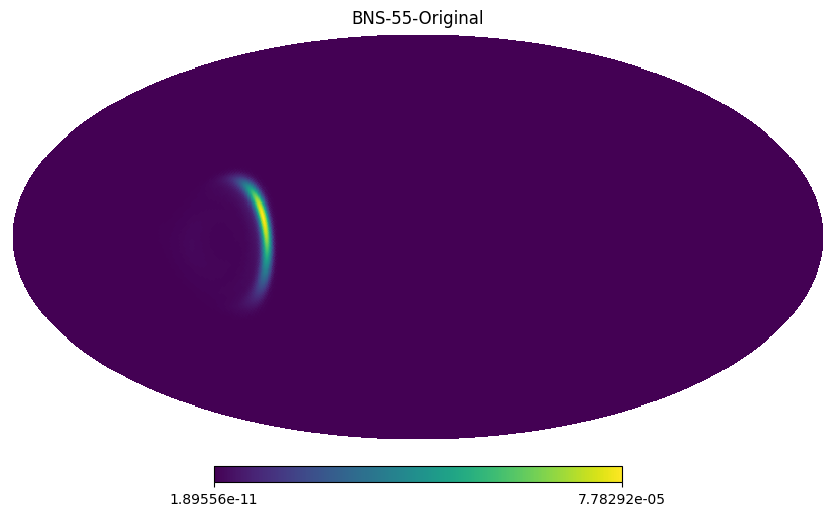

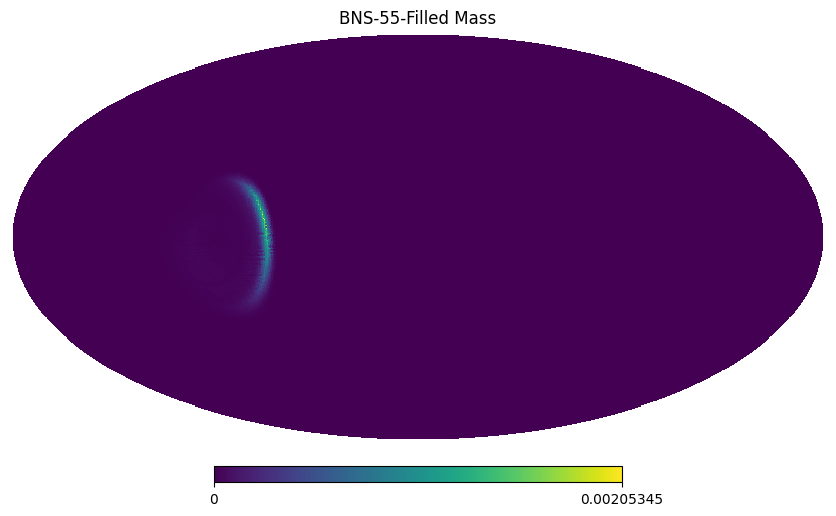

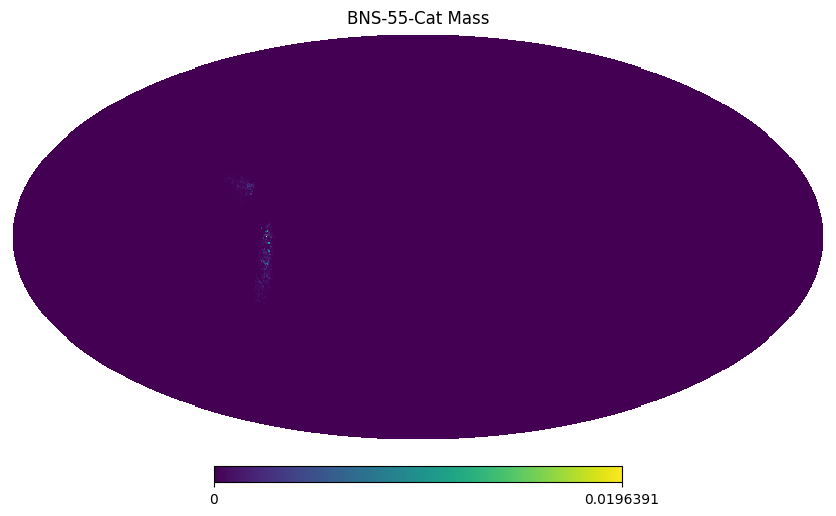

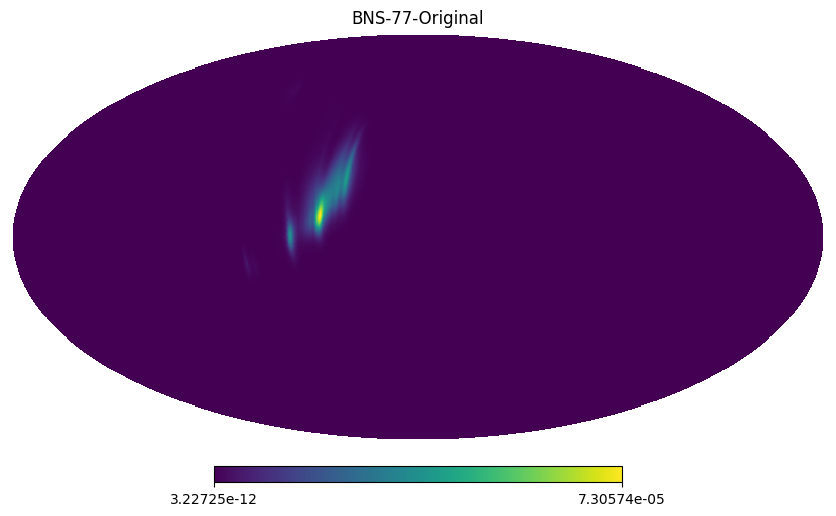

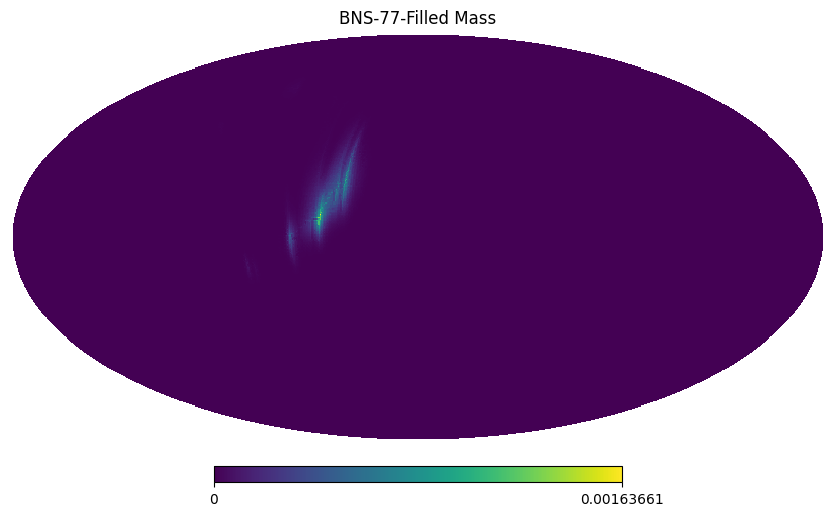

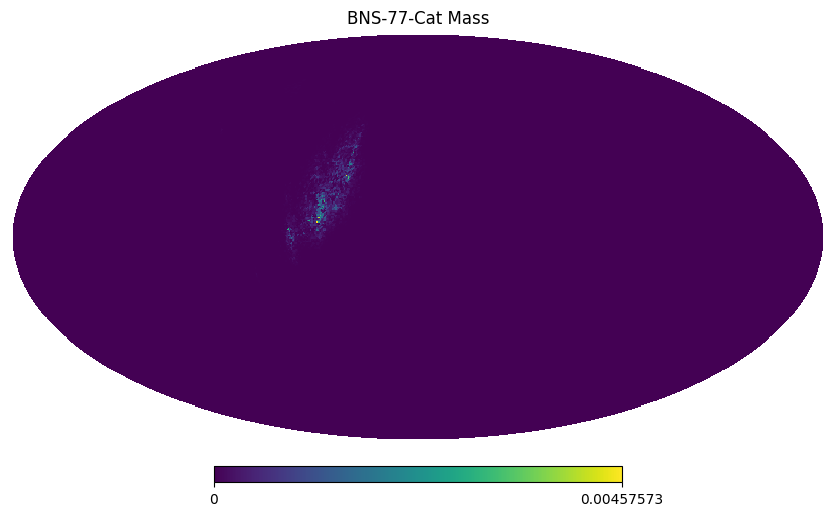

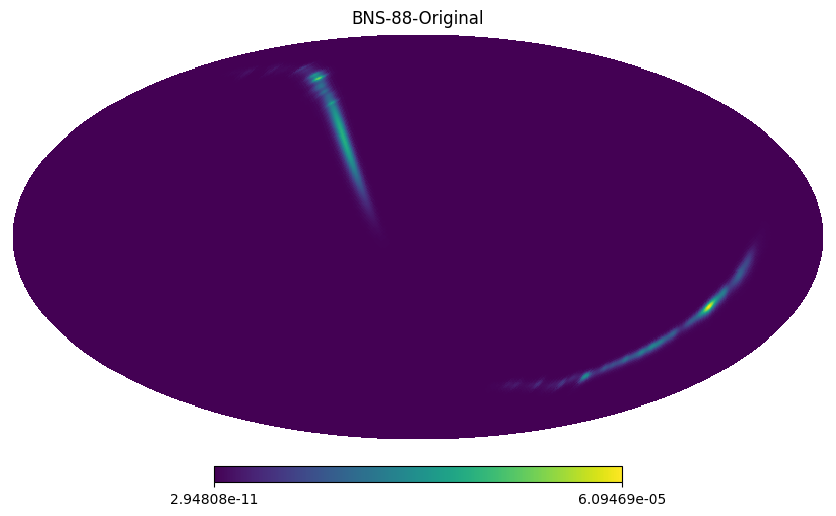

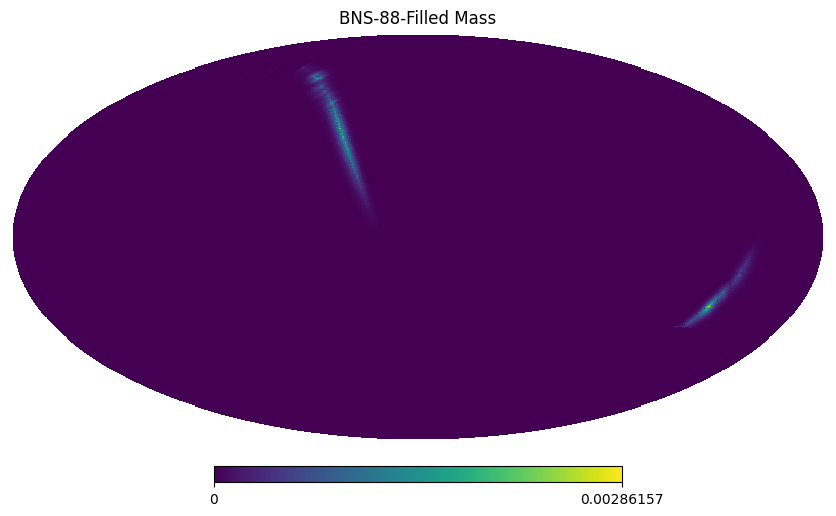

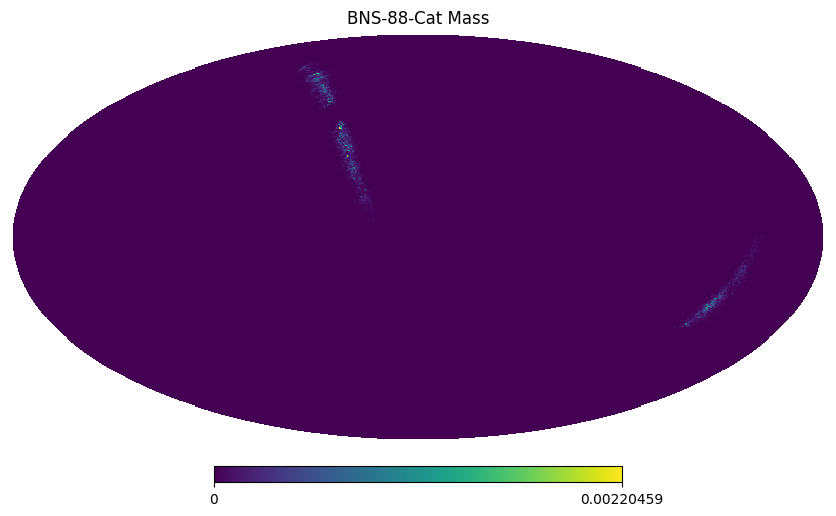

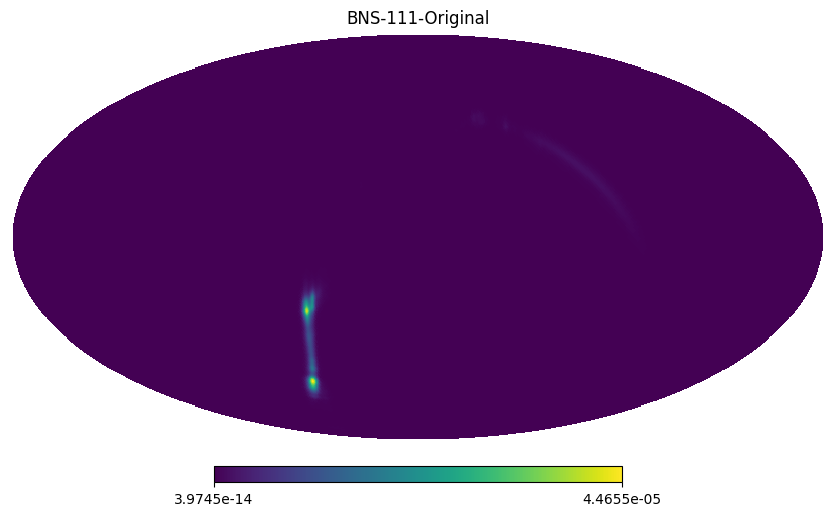

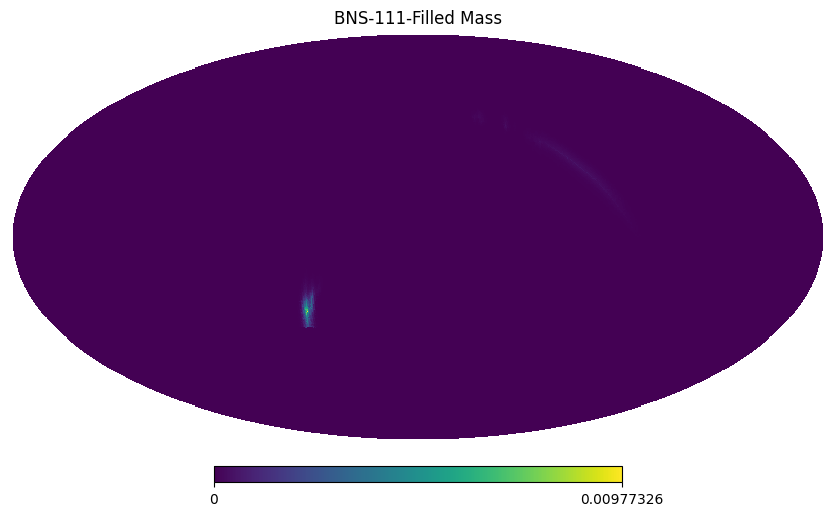

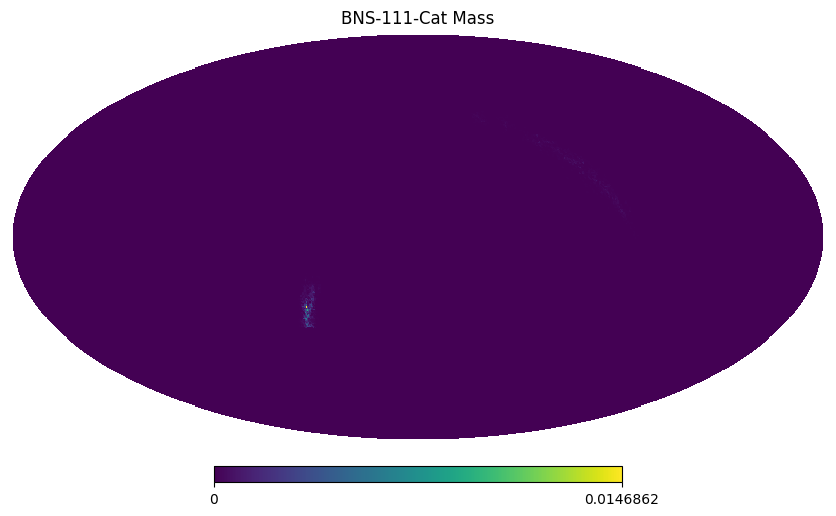

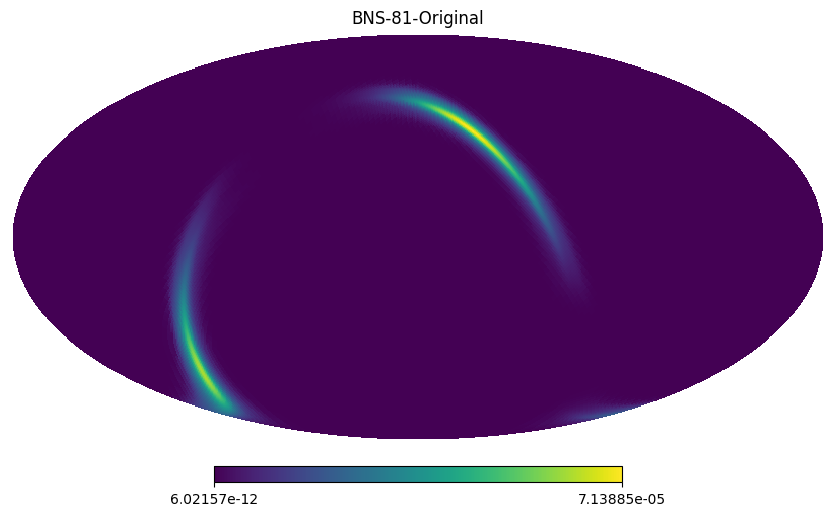

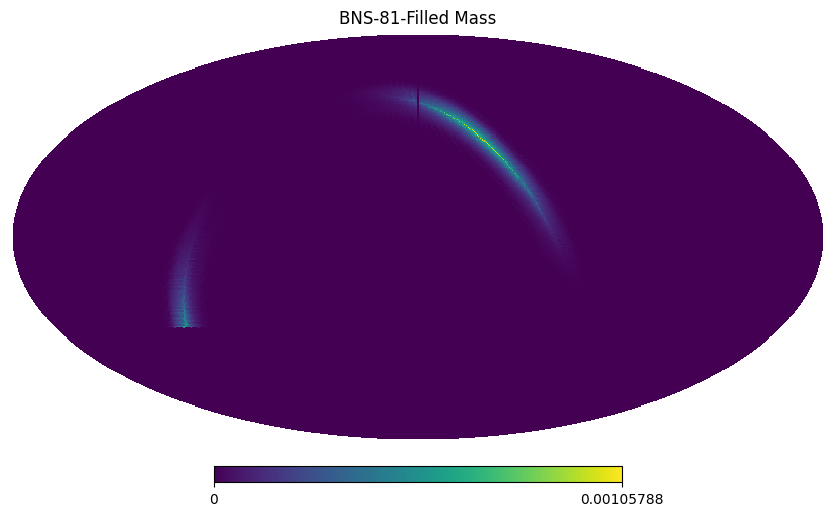

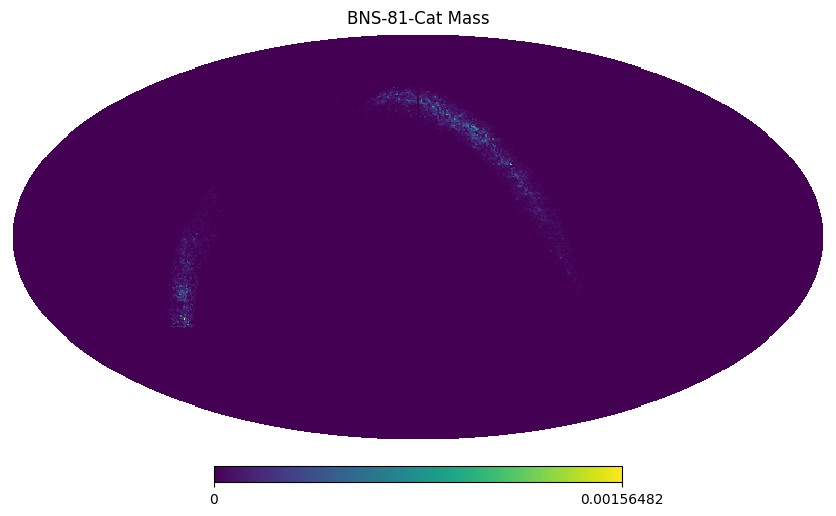

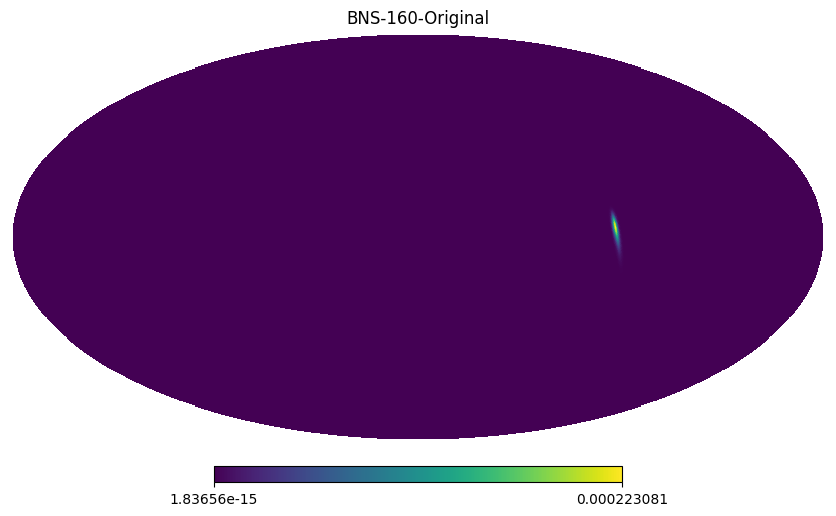

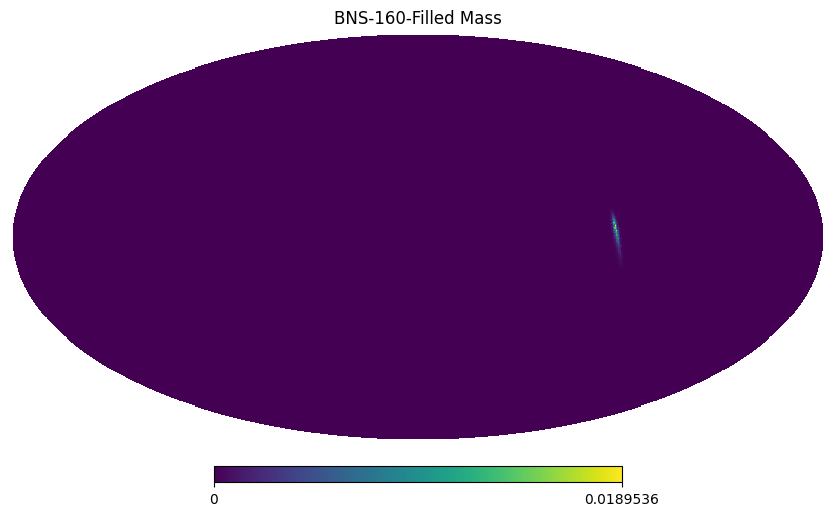

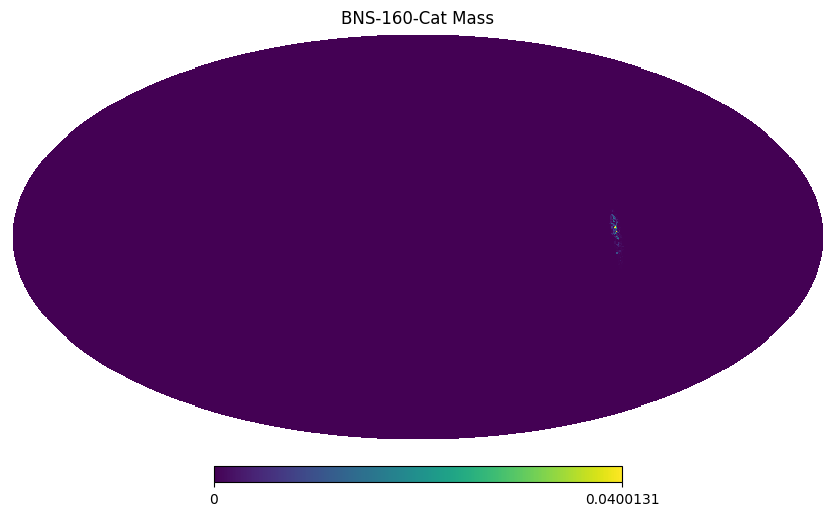

IndexError: index 6024 is out of bounds for axis 0 with size 6024

In [28]:
tiles = pd.read_csv('tiles_GIT_7.csv')
ralist, declist = np.array(tiles['RA_Center'])*u.deg, np.array(tiles['DEC_Center'])*u.deg

nside_skymap = 512
radius = 0.35*u.deg
fact = 1

kl = [33, 40, 55, 77, 88, 111]
#sigma_m = sigma_m[:1008]

for k in kb:
    cs = pd.read_csv('BNS_GalCat/BNS_{}.csv'.format(k))
    sigma_m_nonempty, sigma_m_empty_nodist, sigma_m_empty_dist = np.array(cs['Filled3D']), np.array(cs['Unfilled2D']), np.array(cs['Unfilled3D'])

    skym = ligo.skymap.io.fits.read_sky_map('bns_astro/allsky/{}.fits'.format(k), distances=True)
    skymap = hp.ud_grade(skym[0][0], 512)
    probs = get_probabilities(skymap, ralist, declist)
    tt = get_top_tiles(probs)
    
    z1 = np.zeros(12*512**2)
    z2 = np.zeros(12*512**2)
    
    fullsum = np.sum(sigma_m_nonempty)
    
    for h in range(len(tt)):
        ra = ralist[tt[h]]
        dec = declist[tt[h]]
        vecs = hp.ang2vec(ra.to(u.deg).value, dec.to(u.deg).value, lonlat=True)
        sel_pix = hp.query_disc(nside_skymap, vecs, radius.to(u.rad).value, inclusive=True, fact=fact)
        z1[sel_pix] = (sigma_m_nonempty - sigma_m_empty_dist)[h]/fullsum
        z2[sel_pix] = (sigma_m_empty_dist)[h]/fullsum
    
    hp.mollview(skymap)
    plt.title('BNS-{}-Original'.format(k))
    plt.show()
    hp.mollview(z1)
    plt.title('BNS-{}-Filled Mass'.format(k))
    plt.show()
    hp.mollview(z2)
    plt.title('BNS-{}-Cat Mass'.format(k))
    plt.show()

### Plots of Coverage by various sorting modes

347 0.54940846044796 0.35338436226564873 0.5358469872488274
358 0.2347388107322239 0.19772727142320118 0.2268958880562795
415 0.3228475672665419 0.1393887198177194 0.3225124541837688
448 0.19840987463619955 0.17692632067421254 0.18348116018123226
977 0.21628304407789756 0.20062862903624443 0.20720646749534574


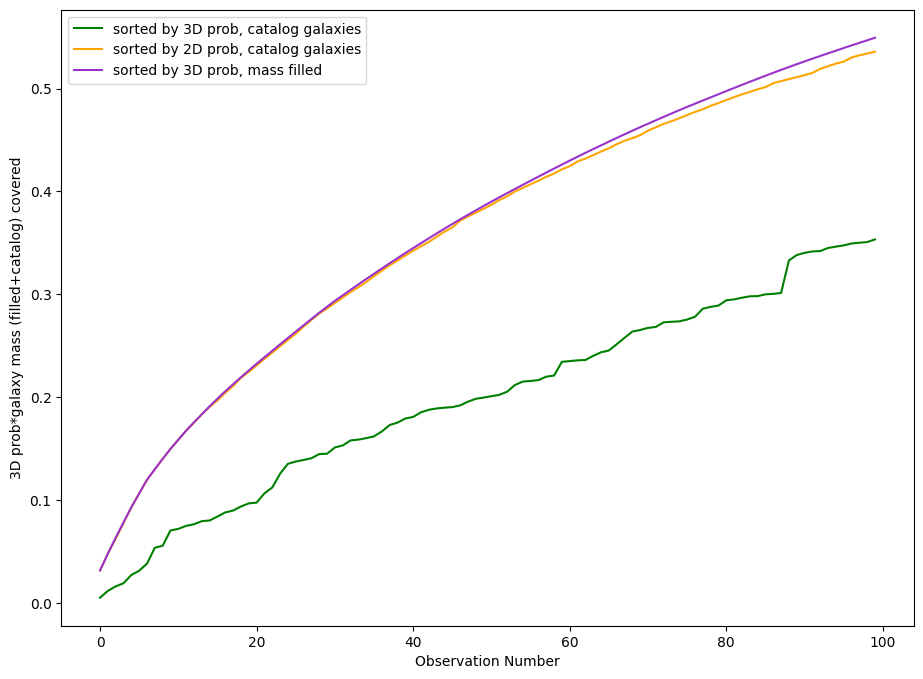

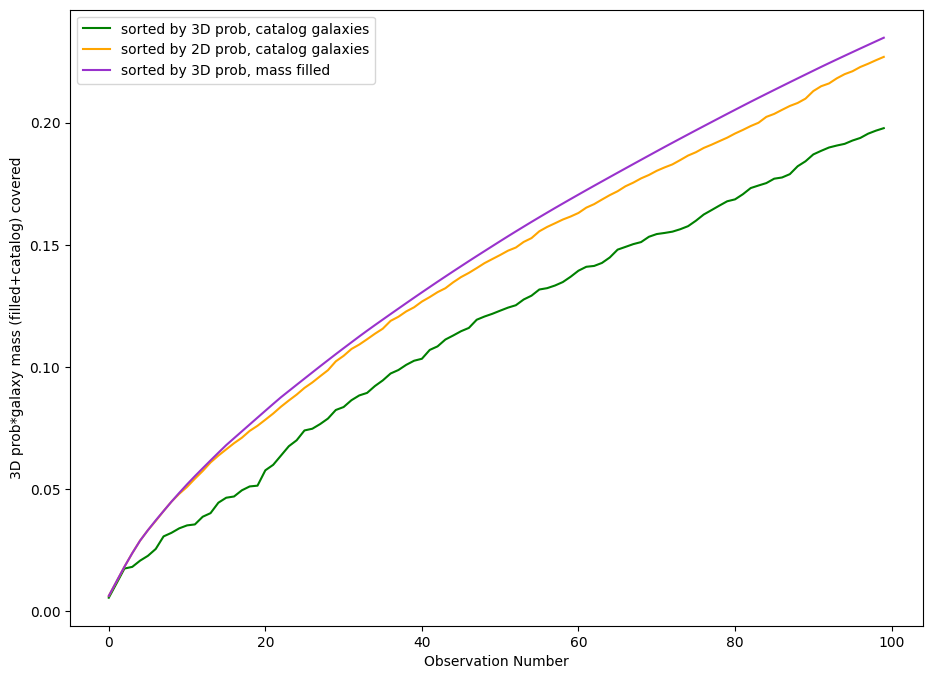

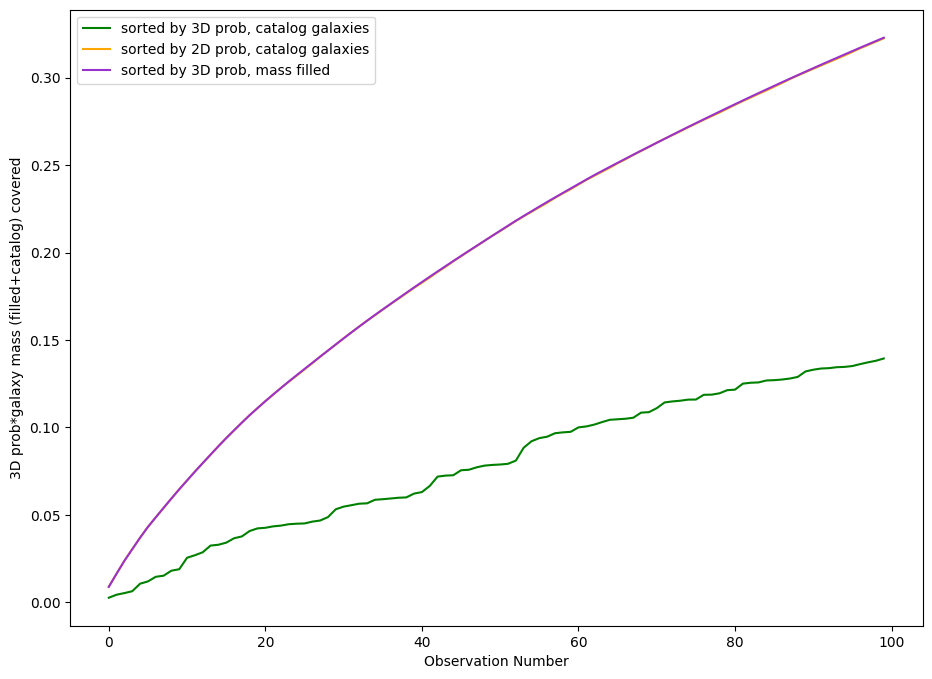

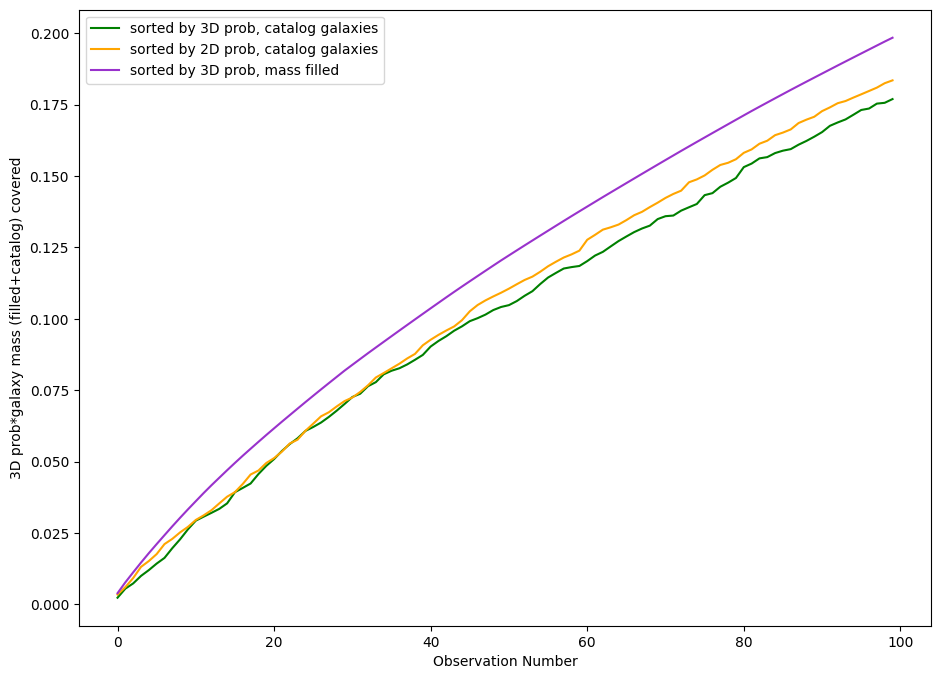

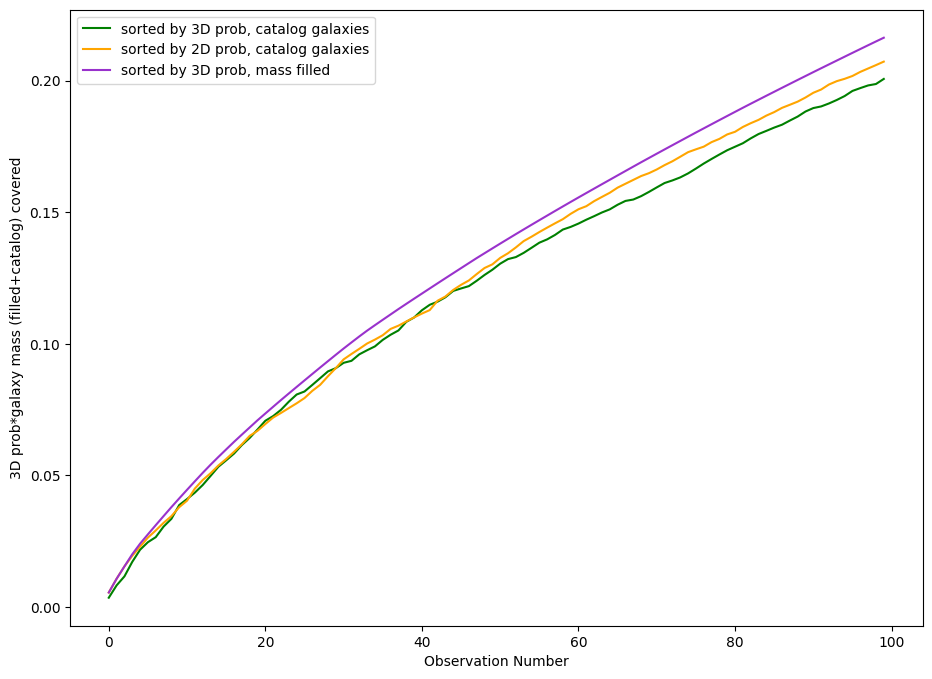

In [26]:
nobs = 100

kb = [33, 40, 55, 77, 88, 111, 81, 160, 238, 8, 334, 289]
kn = [120, 77, 300, 56, 69, 81, 633, 644, 447, 926, 74]
#sigma_m = sigma_m[:1008]

kb = [237,560,550,500,727,737,765]
kn = [177,971,273,730,876]

kn = [631,531,660,797,889,859,849,838]
kb = [347,358,415,448,977]

for k in kb:
    cs = pd.read_csv('BNS_GalCat/BNS_{}.csv'.format(k))
    sigma_m_nonempty, sigma_m_empty_nodist, sigma_m_empty_dist = np.array(cs['Filled3D']), np.array(cs['Unfilled2D']), np.array(cs['Unfilled3D'])

    order_dist = np.flip(np.argsort(sigma_m_empty_dist)[-nobs:])
    order_nodist = np.flip(np.argsort(sigma_m_empty_nodist)[-nobs:])
    order_all = np.flip(np.argsort(sigma_m_nonempty)[-nobs:])


    fullsum = np.sum(sigma_m_nonempty)
    a1 = np.cumsum((sigma_m_nonempty)[order_nodist]) / fullsum
    a2 = np.cumsum((sigma_m_nonempty)[order_dist]) / fullsum
    a3 = np.cumsum((sigma_m_nonempty)[order_all]) / fullsum


    plt.figure(figsize=(11,8))
    plt.plot(a1, color='green', label='sorted by 3D prob, catalog galaxies')
    plt.plot(a2, color='orange', label = 'sorted by 2D prob, catalog galaxies')
    plt.plot(a3, color='darkorchid', label = 'sorted by 3D prob, mass filled')
    plt.legend()
    plt.xlabel('Observation Number')
    plt.ylabel('3D prob*galaxy mass (filled+catalog) covered')
    #plt.title('BNS {}'.format(k))
    #plt.show()

    print(k, a3[-1], a1[-1], a2[-1])

### Next Tasks:

1. Find a way to show why missing mass makes such a diference - 
a. plot skymaps with probabilities from all 3 components
b. show breakup of known / missing mass as dashed lines in cumu plot

2. look for trends as a function of median distance, 90% area - find out where 3d+missing makes most difference, where it is similar to 3d-g, 2d etc etc
a. 100-tile probab as a function of median distance / area
b. histograms of 3 probabs in different distance / area bins

### Overall Results

In [27]:
import pandas as pd
d1 = pd.read_csv('BNS_overall.csv')
d2 = pd.read_csv('NSBH_overall.csv')

d = pd.concat([d1, d2])
d.reset_index(drop=True, inplace=True)
d

,BNS_num,Mean_Dist,P_massfill,P_3dcat,P_2dcat,Area99,Unnamed: 6,NSBH_num,A95
0,33.0,298.21,0.220,0.180,0.220,5220,NaN,NaN,NaN
1,40.0,103.48,0.640,0.370,0.640,4867,NaN,NaN,NaN
2,55.0,228.32,0.320,0.270,0.320,6234,NaN,NaN,NaN
3,77.0,214.84,0.220,0.150,0.220,4179,NaN,NaN,NaN
4,88.0,424.51,0.190,0.170,0.180,4775,NaN,NaN,NaN
5,111.0,320.88,0.510,0.460,0.480,4914,NaN,NaN,NaN
6,81.0,364.04,0.115,0.089,0.101,8916,NaN,NaN,NaN
7,160.0,167.54,0.925,0.868,0.854,212,NaN,NaN,NaN
8,238.0,419.03,0.181,0.156,0.158,6024,NaN,NaN,NaN
9,8.0,209.48,0.729,0.666,0.710,558,NaN,NaN,NaN


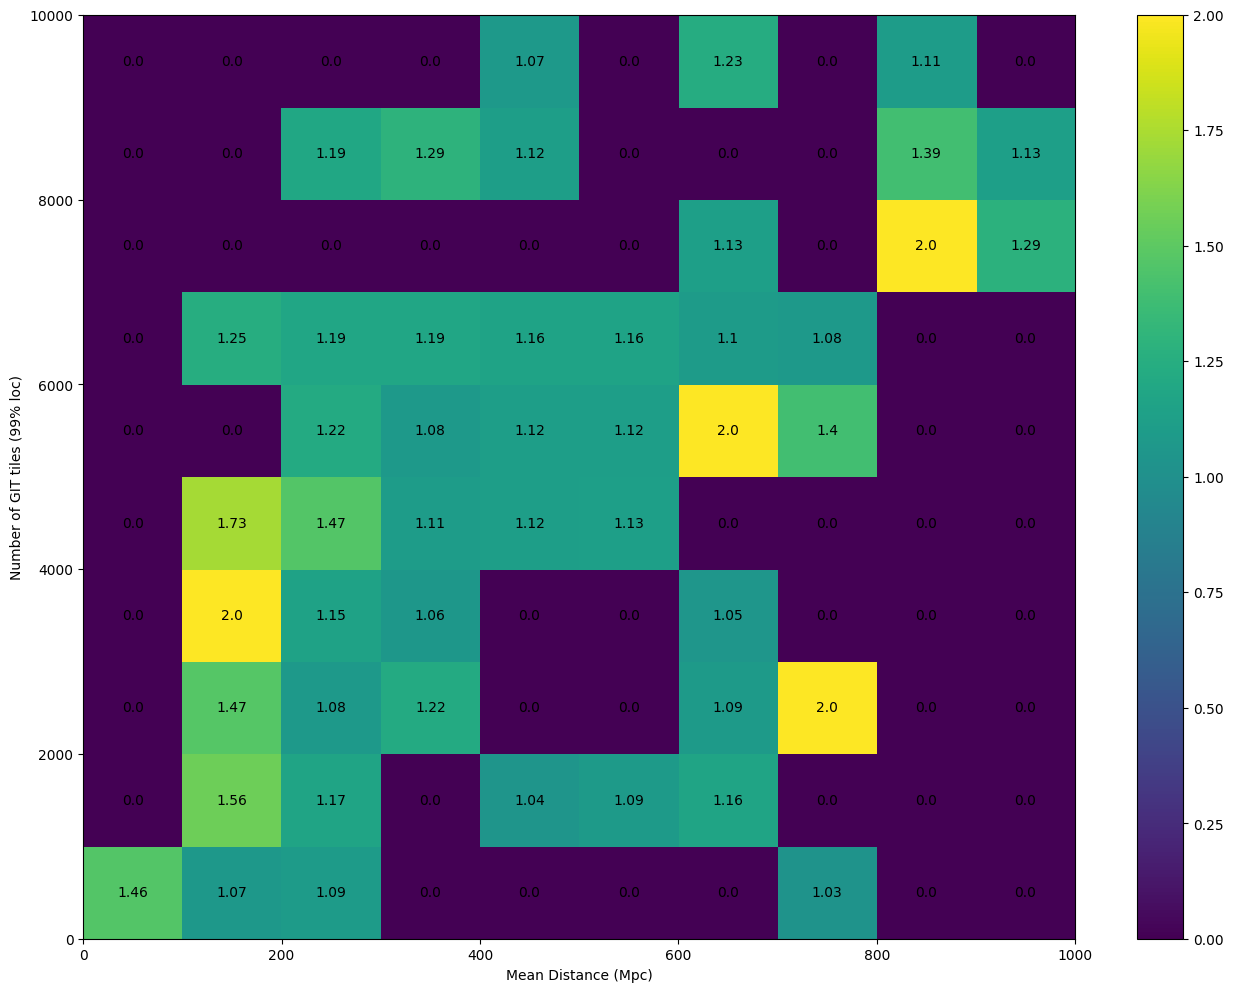

In [28]:
import numpy as np
import matplotlib.pyplot as plt
m = np.zeros((10,10))


dr = np.arange(50,951,100)
ta = np.arange(500,9501,1000)

for i in range(len(dr)):
    for j in range(len(ta)):
        n = d[(np.abs(d.Mean_Dist - dr[i]) <= 50) & (np.abs(d.Area99 - ta[j]) <= 500)]
        
        if len(n) != 0:
            m[j,i] = np.mean(n.P_massfill/n.P_3dcat)
            

            
size = 10
data = np.clip(m,0,2)

# Limits for the extent
x_start = 0
x_end = 1000
y_start = 0
y_end = 10000

extent = [x_start, x_end, y_start, y_end]

# The normal figure
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow(data, extent=extent, origin='lower', interpolation='None', cmap='viridis', aspect='auto')

# Add the text
jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = data[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        ax.text(text_x, text_y, np.round(label,2), color='black', ha='center', va='center')

fig.colorbar(im)
plt.ylabel('Number of GIT tiles (99% loc)')
plt.xlabel('Mean Distance (Mpc)')
plt.show()